In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
from p5lib import *
import pickle
import os.path

%matplotlib inline

### Load and preprocess data

The method ```preprocess_data``` chooses only the selected potential features and combine some columns that are mutually exclusive (such as 4 year college and < 4 year college). It also removes data that does not have Completion or Retention data because those are the target features. 

The result from preprocessing is stored in a pickle file so we can reload it much faster. 

In [71]:
pickle_file = 'reduced_data.pickle'
if os.path.isfile(pickle_file):
    data = pickle.load(open(pickle_file, "rb"))
else:
    data = pd.read_csv('MERGED2013_PP.csv')
    # print data.shape
    data = preprocess_data(data)
    pickle.dump(data, open(pickle_file, "wb"))

print data.shape

(6007, 45)


### Split data into features and targets (X and y) 

We also get rid of data that are outliers (data with retention rate 0)

In [72]:
X = data[['CONTROL', 'DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'PAR_ED_PCT_1STGEN', 
          'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 'UGDS', 
          'WDRAW_DEBT_MDN', 'L4_COLLEGE', 'NPT4', 'NUM4', 
          'PFTFTUG1_EF', 'PFTFAC',
          'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 'AVGFACSAL', 'COSTT4_A',
          'CCSIZSET', 'CCUGPROF', 'CCBASIC', # carnegie classification data
          'C150', 'RET_FT']]

# remove noise, this bumps up the r2 score pretty nicely
# X = X[~((X.RET_FT == 0) & (X.C150 > 0.5))]
# X = X[~((X.C150 == 0) & (X.RET_FT > 0.5))]
# X = X[~((X.C150 == 1) & (X.RET_FT < 0.5))]
# X = X[~((X.RET_FT == 1) & (X.C150 < 0.5))]
X = X[~(X.RET_FT == 0)]

y = X[['C150', 'RET_FT']]
X = X.drop('C150', 1)
X = X.drop('RET_FT', 1)
print X.shape
print y.shape
print len(X.dropna())


(5960, 28)
(5960, 2)
1146


### Fill missing values with the means

In [73]:
fill_cols_with_mean = ['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'WDRAW_DEBT_MDN',
                       'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 
                       'UG25abv', 'NPT4', 'NUM4', 'PFTFTUG1_EF', 'PFTFAC', 'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 
                       'AVGFACSAL', 'COSTT4_A']

for col in fill_cols_with_mean:
    if col in X:
        X[col] = X[col].fillna(X[col].mean())

In [74]:
print_num_data_for_each_features(X)

Number of available data for each feature (not counting the NaN values)
CONTROL             Control (public/private)                      5960
DEBT_MDN            Median debt                                   5960
DEP_INC_AVG         Avg income dependent stu                      5960
GRAD_DEBT_MDN       Median debt complete                          5960
IND_INC_AVG         Avg income independent stu                    5960
INEXPFTE            Expense per FTE student                       5960
PAR_ED_PCT_1STGEN   % 1st gen students                            5960
PAR_ED_PCT_HS       % parent education high school                5960
PAR_ED_PCT_MS       % parent education middle school              5960
PAR_ED_PCT_PS       % parent education post secondary             5960
PCTFLOAN            % Fed student loan                            5960
PCTPELL             % Pell Grant receiver                         5960
UG25abv             % undergrad > 25 yr                           5960
UGDS 

### Scale data

Process non-categorical data using standard scaler so they all have 0 means. 

In [75]:
from sklearn import preprocessing

# take features of type cost/money, and percentage (between 0 and 1) and preprocess with standard scaler
# and then use these preprocessed features for PCA
tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A',
          'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL'
         ]]

scaler = preprocessing.StandardScaler()

scaledX = scaler.fit_transform(tmpX)
print scaledX.shape


(5960, 23)


### Use PCA for dimensional reduction

[  3.27172733e-01   1.23599811e-01   9.71482969e-02   6.85430501e-02
   5.78347093e-02   4.73881578e-02   4.19985272e-02   3.92640360e-02
   3.46822758e-02   2.76923933e-02   2.50142190e-02   2.22809791e-02
   2.20554011e-02   1.60944642e-02   1.16668152e-02   9.24339709e-03
   7.56805099e-03   7.34731055e-03   4.92884099e-03   4.55383044e-03
   2.99018233e-03   6.09843373e-04   3.22675391e-04]


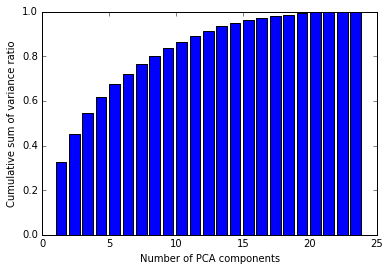

In [76]:
from sklearn.decomposition import PCA

pca = PCA(n_components=scaledX.shape[1])
pca.fit(scaledX)

print pca.explained_variance_ratio_

plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative sum of variance ratio')
plt.xlabel('Number of PCA components')
plt.show()

In [77]:
pca = PCA(n_components=19)
pca.fit(scaledX)
reducedX = pca.transform(scaledX)

# reducedX is the chosen top PCA components
print reducedX.shape

(5960, 19)


### Add categorical features as one hot encoded

In [78]:
tmp1X = np.array(pd.get_dummies(X['CONTROL']))
tmp2X = X['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 

tmp3X = np.array(pd.get_dummies(X['CCSIZSET']))
tmp4X = np.array(pd.get_dummies(X['CCUGPROF']))
tmp5X = np.array(pd.get_dummies(X['CCBASIC']))

print reducedX.shape
print tmp1X.shape, tmp2X.shape, tmp3X.shape, tmp4X.shape, tmp5X.shape

finalX = np.concatenate((reducedX, tmp1X, tmp2X, tmp3X, tmp4X, tmp5X), axis=1)

print finalX.shape

(5960, 19)
(5960, 3) (5960, 1) (5960, 17) (5960, 14) (5960, 33)
(5960, 87)


### Train / test split

Optionally store the train/test split in a pickle file if we want to keep the same train/test data. In order to do this, comment out the os.remove line. 

(4768, 87)
(1192, 87)
(4768, 2)
(1192, 2)
       y_test c150  y_train c150
count  1192.000000   4768.000000
mean      0.531137      0.526589
std       0.240352      0.236492
min       0.000000      0.000000
25%       0.338434      0.336024
50%       0.551007      0.552863
75%       0.732149      0.714278
max       1.000000      1.000000
        y_test ret  y_train ret
count  1192.000000  4768.000000
mean      0.699588     0.697753
std       0.167856     0.168549
min       0.064500     0.019200
25%       0.596075     0.588275
50%       0.707950     0.709700
75%       0.820425     0.818200
max       1.000000     1.000000


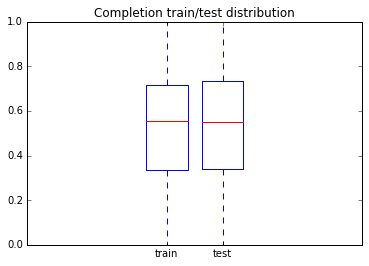

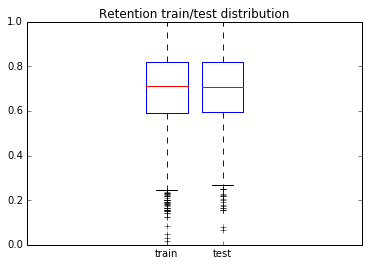

In [79]:
from sklearn import cross_validation as cv

pickle_file = 'm5-split_data.pickle'

# os.remove(pickle_file) # clear cache (delete pickle). Comment this out to keep the same train/test data over multiple runs
if os.path.isfile(pickle_file):
    print "loading split_data from pickle"
    split_data = pickle.load(open(pickle_file, "rb"))
    X_train, X_test, y_train, y_test = split_data['X_train'], split_data['X_test'], split_data['y_train'], split_data['y_test']
else:
    y = np.array(y)
    X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
    split_data = {
        'X_train': X_train,
        'X_test':  X_test,
        'y_train': y_train,
        'y_test':  y_test,        
    }
    pickle.dump(split_data, open(pickle_file, "wb"))

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# Check if the train / test has similar distribution
print pd.DataFrame(data={'y_train c150': pd.Series(y_train[:,0]).describe(),
                         'y_test c150': pd.Series(y_test[:,0]).describe(),
                        })
print pd.DataFrame(data={'y_train ret': pd.Series(y_train[:,1]).describe(),
                         'y_test ret': pd.Series(y_test[:,1]).describe(),
                        })
plt.title("Completion train/test distribution")
plt.boxplot([y_train[:,0], y_test[:,0]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()
plt.title("Retention train/test distribution")
plt.boxplot([y_train[:,1], y_test[:,1]], labels=['train', 'test'], positions=[0.2, 0.4])
plt.show()


## Build models

X_train contains the following data:
* The first 15 columns are PCA reduced data from the 23 numerical features
* Column 16-19 are one hot encoded categorical data (4 year college, public, private, profit)
* Column 20-83 are one hot encoded remaining caegorical data (Carnegie classifications) 

### Decision Tree

--- R2 Completion ---
best params: {'max_depth': 6}
R2 score on train data: 0.644523251849
R2 score on test  data: 0.509153265859
--- R2 Retention ---
best params: {'max_depth': 5}
R2 score on train data: 0.300698714551
R2 score on test  data: 0.208221144436
--- MSE Completion ---
MSE on train data: 0.0198771826248
MSE on test  data: 0.0283319324819
--- MSE Retention ---
MSE on train data: 0.0198621692162
MSE on test  data: 0.0222902379184
--- MAE Completion ---
MAE on train data: 0.10440287291
MAE on test  data: 0.123590237546
--- MAE Retention ---
MAE on train data: 0.102588686206
MAE on test  data: 0.107499288652


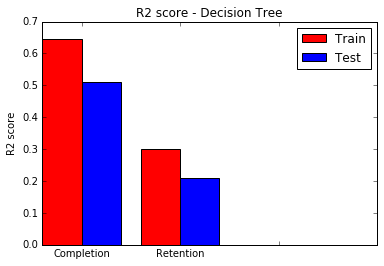

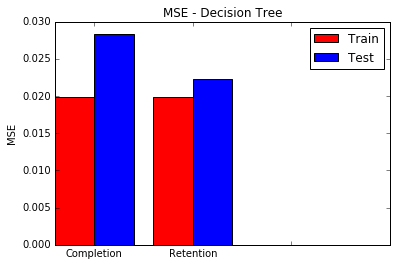

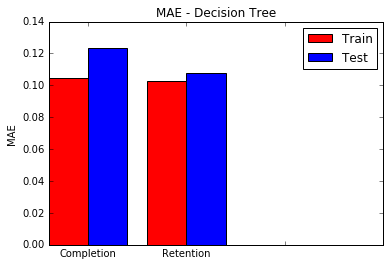

In [80]:
DT23_model = build_DecisionTree_model(X_train[:,:23], X_test[:,:23], y_train, y_test)

--- R2 Completion ---
best params: {'max_depth': 9}
R2 score on train data: 0.766118531628
R2 score on test  data: 0.500363206508
--- R2 Retention ---
best params: {'max_depth': 5}
R2 score on train data: 0.301118496858
R2 score on test  data: 0.208530236021
--- MSE Completion ---
MSE on train data: 0.0130779430259
MSE on test  data: 0.0288392993455
--- MSE Retention ---
MSE on train data: 0.0198502461905
MSE on test  data: 0.022281536341
--- MAE Completion ---
MAE on train data: 0.0820177318513
MAE on test  data: 0.121343173965
--- MAE Retention ---
MAE on train data: 0.10253353188
MAE on test  data: 0.107646271714


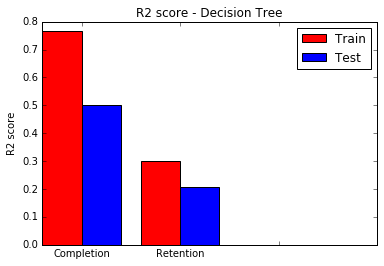

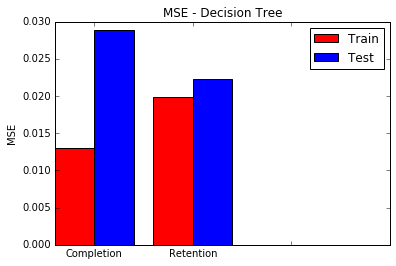

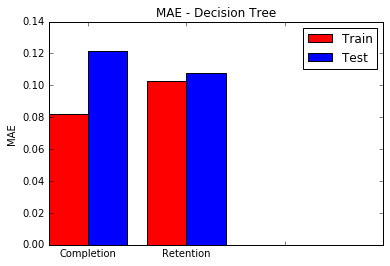

In [81]:
DT_model = build_DecisionTree_model(X_train, X_test, y_train, y_test)

### SVR

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.754356377238
R2 score on test  data: 0.653180386494
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.474381371691
R2 score on test  data: 0.350280815756
--- MSE Completion ---
MSE on train data: 0.0137356470589
MSE on test  data: 0.0200186110853
--- MSE Retention ---
MSE on train data: 0.0149290818648
MSE on test  data: 0.0182909597739
--- MAE Completion ---
MAE on train data: 0.0895271009434
MAE on test  data: 0.107023999274
--- MAE Retention ---
MAE on train data: 0.0882688691996
MAE on test  data: 0.0973750624609


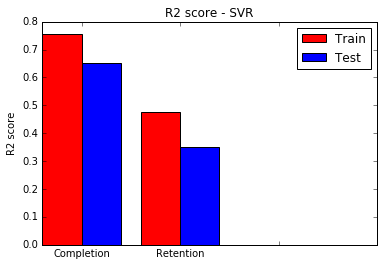

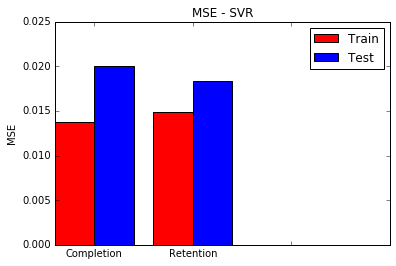

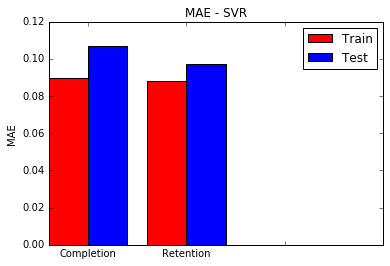

In [82]:
SVR23_model = build_SVR_model(X_train[:,:23], X_test[:,:23], y_train, y_test)

--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.765671193852
R2 score on test  data: 0.653203095893
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.493233524092
R2 score on test  data: 0.346081821604
--- MSE Completion ---
MSE on train data: 0.0131029567989
MSE on test  data: 0.0200173002868
--- MSE Retention ---
MSE on train data: 0.0143936264769
MSE on test  data: 0.0184091702793
--- MAE Completion ---
MAE on train data: 0.0879956611277
MAE on test  data: 0.10727036259
--- MAE Retention ---
MAE on train data: 0.0871565484507
MAE on test  data: 0.0980449464097


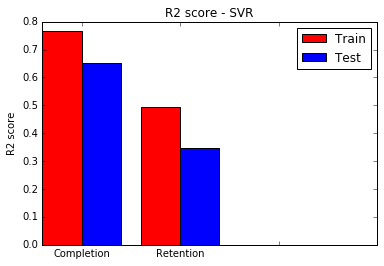

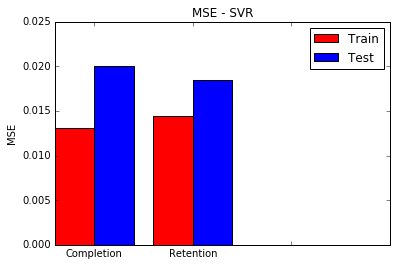

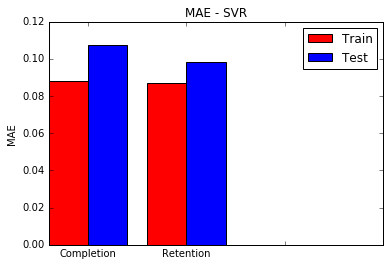

In [83]:
SVR_model = build_SVR_model(X_train, X_test, y_train, y_test)

### KNN

--- R2 Completion ---
best params: {'n_neighbors': 14}
R2 score on train data: 0.724448160477
R2 score on test  data: 0.663166268097
--- R2 Retention ---
best params: {'n_neighbors': 17}
R2 score on train data: 0.407477321503
R2 score on test  data: 0.353662878335
--- MSE Completion ---
MSE on train data: 0.0154080239151
MSE on test  data: 0.0194422207303
--- MSE Retention ---
MSE on train data: 0.0168293494516
MSE on test  data: 0.0181957476083
--- MAE Completion ---
MAE on train data: 0.090434482247
MAE on test  data: 0.101498915522
--- MAE Retention ---
MAE on train data: 0.0917571086656
MAE on test  data: 0.0948529411765


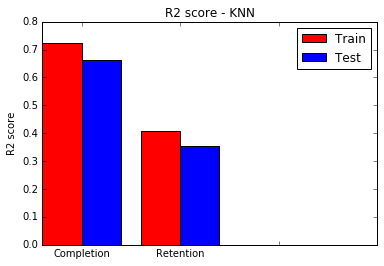

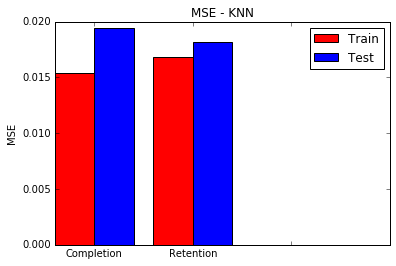

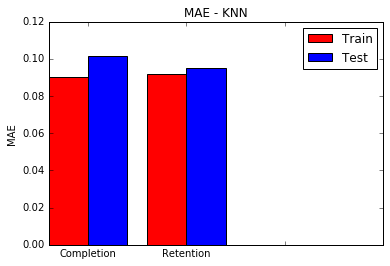

In [84]:
KNN23_model = build_KNN_model(X_train[:,:23], X_test[:,:23], y_train, y_test)

--- R2 Completion ---
best params: {'n_neighbors': 9}
R2 score on train data: 0.746663301763
R2 score on test  data: 0.653403998266
--- R2 Retention ---
best params: {'n_neighbors': 17}
R2 score on train data: 0.412615247348
R2 score on test  data: 0.351801751739
--- MSE Completion ---
MSE on train data: 0.0141658205286
MSE on test  data: 0.0200057040958
--- MSE Retention ---
MSE on train data: 0.0166834175697
MSE on test  data: 0.0182481422313
--- MAE Completion ---
MAE on train data: 0.0861002113454
MAE on test  data: 0.101070580859
--- MAE Retention ---
MAE on train data: 0.0910538689301
MAE on test  data: 0.0944314202527


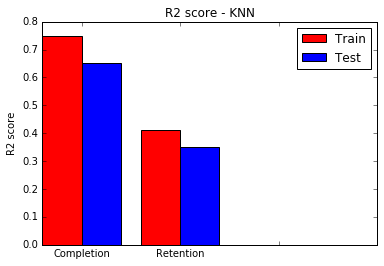

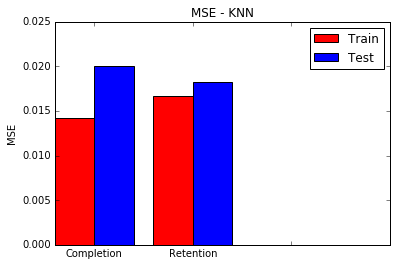

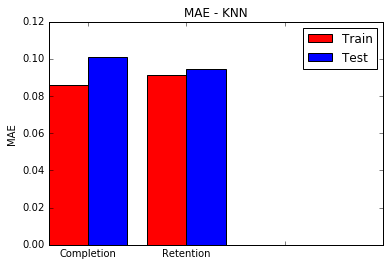

In [85]:
KNN_model = build_KNN_model(X_train, X_test, y_train, y_test)

### Random Forest

--- R2 Completion ---
R2 score on train data: 0.952121266017
R2 score on test  data: 0.652038597025
--- R2 Retention ---
R2 score on train data: 0.903783587002
R2 score on test  data: 0.330626091213
--- MSE Completion ---
MSE on train data: 0.00267723372673
MSE on test  data: 0.0200845157758
--- MSE Retention ---
MSE on train data: 0.00273282305653
MSE on test  data: 0.0188442815546
--- MAE Completion ---
MAE on train data: 0.0371589910008
MAE on test  data: 0.103485634382
--- MAE Retention ---
MAE on train data: 0.0362160821787
MAE on test  data: 0.0964512389974


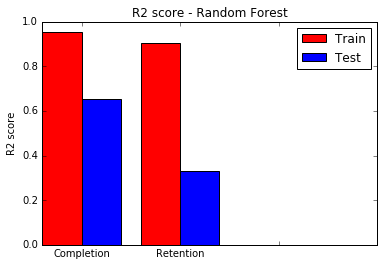

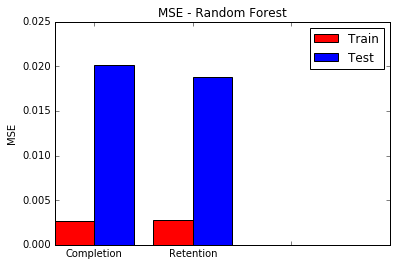

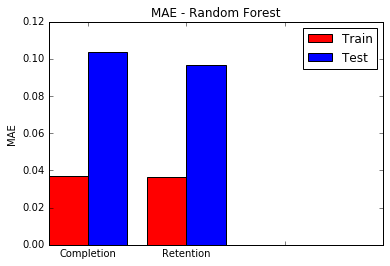

In [86]:
RF23_model = build_RandomForest_model(X_train[:,:23], X_test[:,:23], y_train, y_test, n_estimators=50)

--- R2 Completion ---
R2 score on train data: 0.95420423143
R2 score on test  data: 0.659613504724
--- R2 Retention ---
R2 score on train data: 0.904440921824
R2 score on test  data: 0.345717228325
--- MSE Completion ---
MSE on train data: 0.00256076061243
MSE on test  data: 0.0196472881067
--- MSE Retention ---
MSE on train data: 0.00271415285568
MSE on test  data: 0.0184194343459
--- MAE Completion ---
MAE on train data: 0.0363754398771
MAE on test  data: 0.102008811011
--- MAE Retention ---
MAE on train data: 0.0360873105619
MAE on test  data: 0.0949593970819


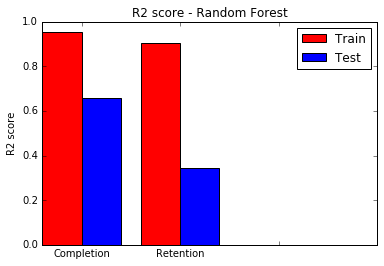

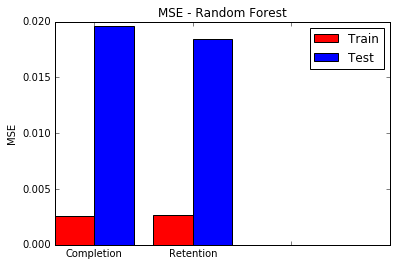

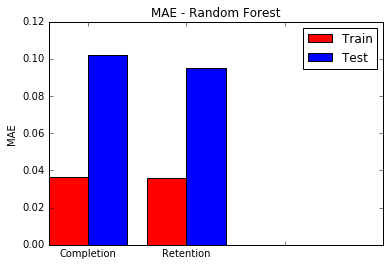

In [87]:
RF_model = build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=50)

### Comparing R2, MSE and MAE between models with 19 features

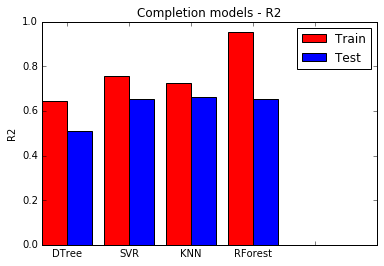

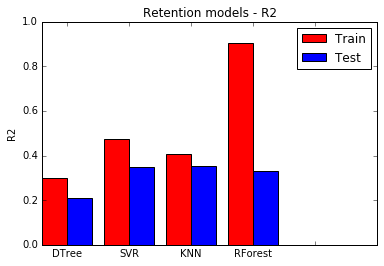

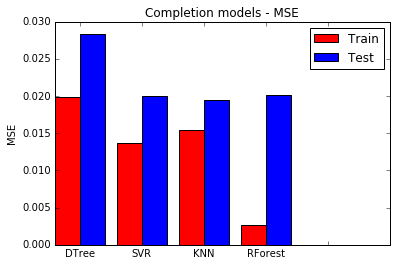

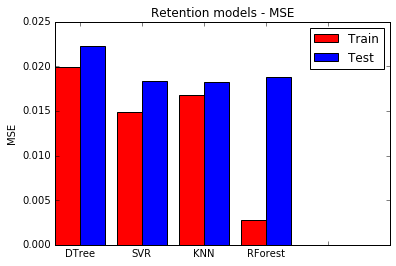

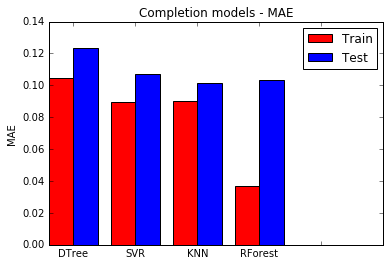

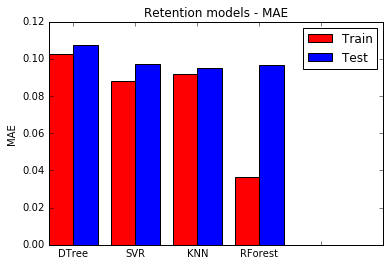

In [88]:
plot_compare_metric([DT23_model, SVR23_model, KNN23_model, RF23_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT23_model, SVR23_model, KNN23_model, RF23_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT23_model, SVR23_model, KNN23_model, RF23_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')
    

### Comparing R2, MSE and MAE between models with 83 features

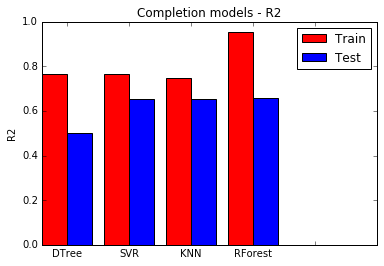

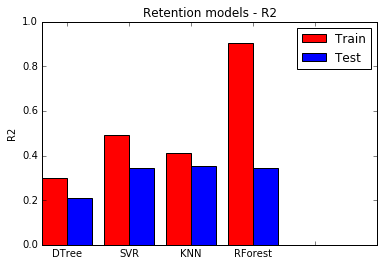

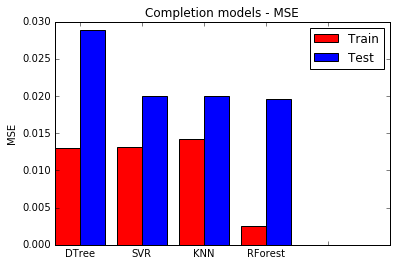

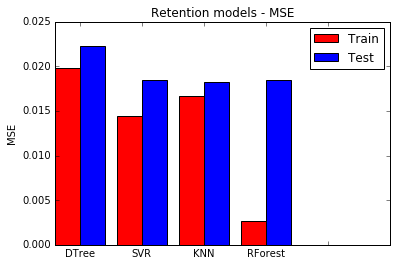

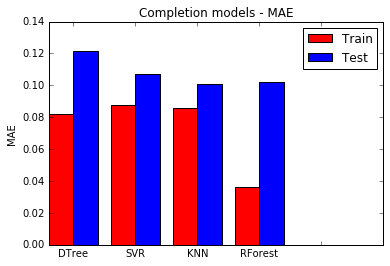

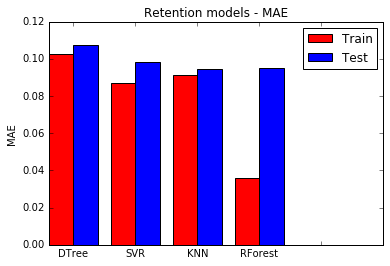

In [89]:
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='r2')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mse')
plot_compare_metric([DT_model, SVR_model, KNN_model, RF_model], 
                    ['DTree', 'SVR', 'KNN', 'RForest'], 
                    metric='mae')

### Comparing R2, MSE, MAE on test data between models with 19 and 83 features

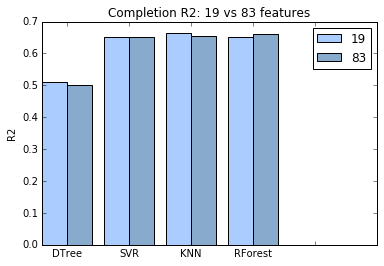

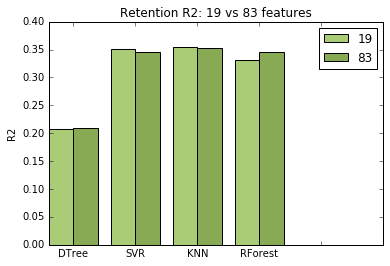

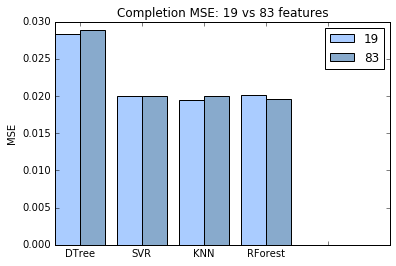

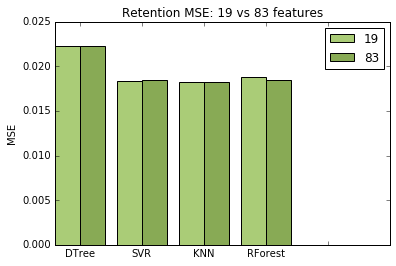

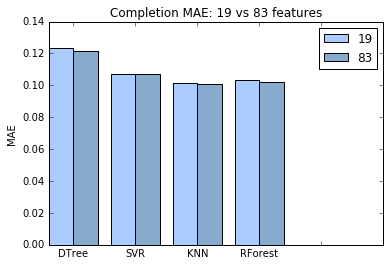

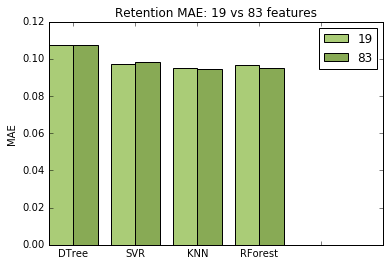

In [90]:
plot_model_improvement([DT23_model, SVR23_model, KNN23_model, RF23_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='r2')
plot_model_improvement([DT23_model, SVR23_model, KNN23_model, RF23_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='mse')
plot_model_improvement([DT23_model, SVR23_model, KNN23_model, RF23_model], 
                       [DT_model, SVR_model, KNN_model, RF_model],
                       ['DTree', 'SVR', 'KNN', 'RForest'],
                       metric='mae')

### Using Completion model to help predict Retention rate

Because the Completion model has a pretty good r2 score compared to the Retention model, we could use the Completion model to help predict the Retention. This might work because there is a clear positive linear correlation between completion and retention.

For this improvement, the implementation for the completion model is exactly the same. However, the retention model will have one more feature--the completion rate. The retention model is trained using the same X_train + y1_train (the completion rate data). When doing prediction on the test set, the retention model takes the X_test + the predicted completion rate from the completion model.

In [91]:
from sklearn.ensemble import RandomForestRegressor

def print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- R2 Completion ---"
    if hasattr(reg1, 'best_params_'):
        print "best params: {}".format(reg1.best_params_)
    r2_train_reg1 = print_r2score(reg1, X_train, y1_train)
    r2_test_reg1  = print_r2score(reg1, X_test, y1_test, test=True)
    print "--- R2 Retention ---"
    if hasattr(reg2, 'best_params_'):
        print "best params: {}".format(reg2.best_params_)
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    r2_train_reg2 = print_r2score(reg2, X_train1, y2_train)
    r2_test_reg2  = print_r2score(reg2, X_test1, y2_test, test=True)

    return {'reg1': {'train': r2_train_reg1, 'test': r2_test_reg1 },
            'reg2': {'train': r2_train_reg2, 'test': r2_test_reg2 }}

def print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- MSE Completion ---"
    mse_train_reg1 = print_mse(reg1, X_train, y1_train)
    mse_test_reg1 = print_mse(reg1, X_test, y1_test, test=True)
    print "--- MSE Retention ---"
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    mse_train_reg2 = print_mse(reg2, X_train1, y2_train)
    mse_test_reg2 = print_mse(reg2, X_test1, y2_test, test=True)
    
    return {'reg1': {'train': mse_train_reg1, 'test': mse_test_reg1 },
            'reg2': {'train': mse_train_reg2, 'test': mse_test_reg2 }}

def print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted):
    print "--- MAE Completion ---"
    mae_train_reg1 = print_mae(reg1, X_train, y1_train)
    mae_test_reg1 = print_mae(reg1, X_test, y1_test, test=True)
    print "--- MAE Retention ---"
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    mae_train_reg2 = print_mae(reg2, X_train1, y2_train)
    mae_test_reg2 = print_mae(reg2, X_test1, y2_test, test=True)
    
    return {'reg1': {'train': mae_train_reg1, 'test': mae_test_reg1 },
            'reg2': {'train': mae_train_reg2, 'test': mae_test_reg2 }}

# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_RandomForest_model_nested(X_train, X_test, y_train, y_test, n_estimators=50):
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    reg1 = RandomForestRegressor(n_estimators=n_estimators)
    reg1.fit(X_train, y1_train)

    reg2 = RandomForestRegressor(n_estimators=n_estimators)
    
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    y1_test_predicted = reg1.predict(X_test)
    
    r2 = print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mse = print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mae = print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
#     plot_err_metric(r2, metric='R2 score', model='Random Forest nested')
#     plot_err_metric(mse, metric='MSE', model='Random Forest nested')
#     plot_err_metric(mae, metric='MAE', model='Random Forest nested')
    
    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

RF_nested = build_RandomForest_model_nested(X_train[:,:23], X_test[:,:23], y_train, y_test)


--- R2 Completion ---
R2 score on train data: 0.951000672433
R2 score on test  data: 0.652155766071
--- R2 Retention ---
R2 score on train data: 0.908560292267
R2 score on test  data: 0.350929305299
--- MSE Completion ---
MSE on train data: 0.00273989392445
MSE on test  data: 0.0200777527167
--- MSE Retention ---
MSE on train data: 0.00259715087884
MSE on test  data: 0.0182727034311
--- MAE Completion ---
MAE on train data: 0.0373079871838
MAE on test  data: 0.103633958312
--- MAE Retention ---
MAE on train data: 0.0341286983807
MAE on test  data: 0.0950431191173


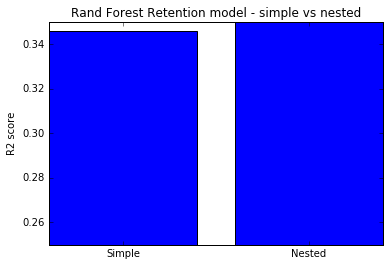

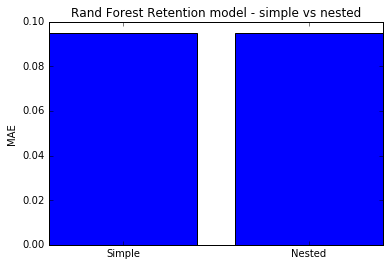

In [92]:
# Comparison of r2 score between simple vs nested model (using RandomForest) 
ret_r2  = [RF_model['r2']['reg2']['test'], RF_nested['r2']['reg2']['test']]
ret_mae  = [RF_model['mae']['reg2']['test'], RF_nested['mae']['reg2']['test']]

plt.title('Rand Forest Retention model - simple vs nested')
ax = plt.subplot(111)
ax.set_ylim([0.25, 0.35])
ax.bar(np.array(range(2)), ret_r2, width=0.8, color='b')
plt.ylabel('R2 score')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()

plt.title('Rand Forest Retention model - simple vs nested')
ax = plt.subplot(111)
# ax.set_ylim([0.25, 0.50])
ax.bar(np.array(range(2)), ret_mae, width=0.8, color='b')
plt.ylabel('MAE')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()


### SVR Nested Model

In [93]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_SVR_model_nested(X_train, X_test, y_train, y_test, cv=3, params=None):
    y1_train, y1_test, y2_train, y2_test = split_y(y_train, y_test)

    if params == None:
        params = {'C': np.logspace(-1, 1, 2), 'gamma': np.logspace(-1, 1, 2), 'epsilon': np.logspace(-1, 1, 2)}
    reg = SVR()
    scorer = default_scorer
    reg1 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    reg1.fit(X_train, y1_train)

    reg = SVR()
    reg2 = GridSearchCV(reg, params, scoring=scorer, cv=cv)
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    y1_test_predicted = reg1.predict(X_test)

    r2 = print_r2_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mse = print_mse_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)
    mae = print_mae_summary_nested(reg1, reg2, X_train, X_test, y1_train, y1_test, y2_train, y2_test, y1_test_predicted)

    return {'reg1': reg1, 'reg2': reg2, 'r2': r2, 'mse': mse, 'mae': mae}

SVR_nested = build_SVR_model_nested(X_train[:,:23], X_test[:,:23], y_train, y_test)


--- R2 Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.754356377238
R2 score on test  data: 0.653180386494
--- R2 Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.497410025349
R2 score on test  data: 0.345460866697
--- MSE Completion ---
MSE on train data: 0.0137356470589
MSE on test  data: 0.0200186110853
--- MSE Retention ---
MSE on train data: 0.0142750018205
MSE on test  data: 0.0184266514643
--- MAE Completion ---
MAE on train data: 0.0895271009434
MAE on test  data: 0.107023999274
--- MAE Retention ---
MAE on train data: 0.0853151272982
MAE on test  data: 0.0978521430484


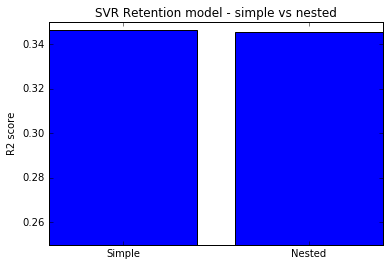

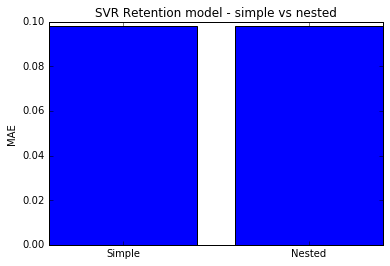

In [94]:
# Comparison of r2 score between simple vs nested model (using SVR model) 
ret_r2  = [SVR_model['r2']['reg2']['test'], SVR_nested['r2']['reg2']['test']]
ret_mae  = [SVR_model['mae']['reg2']['test'], SVR_nested['mae']['reg2']['test']]

plt.title('SVR Retention model - simple vs nested')
ax = plt.subplot(111)
ax.set_ylim([0.25, 0.35])
ax.bar(np.array(range(2)), ret_r2, width=0.8, color='b')

plt.ylabel('R2 score')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()

plt.title('SVR Retention model - simple vs nested')
ax = plt.subplot(111)
# ax.set_ylim([0.10, 0.11])
ax.bar(np.array(range(2)), ret_mae, width=0.8, color='b')

plt.ylabel('MAE')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()


### Sensitivity analysis

Sensitivity analysis is done by choosing 100 random data from the training set and changing the input by a little bit to see how different the prediction result for each model is. The difference in prediction result are collected and visualized using whisker plot to see the stability of the model.

Statistical analysis of difference in result when the input have small changes


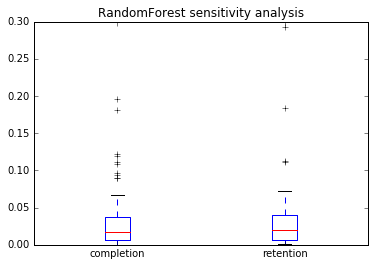

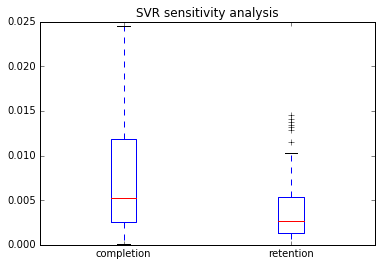

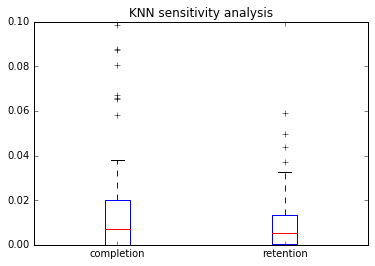

In [95]:

def final_nested_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    X1 = np.concatenate((X, reshape_y(y1_predicted)), axis=1)
    y2_predicted = reg2.predict(X1)
    return y1_predicted, y2_predicted

def final_model_predict(reg1, reg2, X):
    y1_predicted = reg1.predict(X)
    y2_predicted = reg2.predict(X)
    return y1_predicted, y2_predicted

def sensitivity_analysis(reg1, reg2, data, title=''):
    delta_y1, delta_y2 = [], []
    
    for i, row in enumerate(data):
        X_nearby = row.copy()
        for j, a in enumerate(X_nearby):
            span = X_train[:,j].max() - X_train[:,j].min()
            if j < 15:
                X_nearby[j] += span/200

        y1p, y2p = final_model_predict(reg1, reg2, [row]) # predicted value
        y1pn, y2pn = final_model_predict(reg1, reg2, [X_nearby]) # predicted nearby value
        delta_y1.append(abs(y1pn[0] - y1p[0]))
        delta_y2.append(abs(y2pn[0] - y2p[0]))
    
    plt.title("{} sensitivity analysis".format(title))
    plt.boxplot([delta_y1, delta_y2], labels=['completion', 'retention'])
    plt.show()

print "Statistical analysis of difference in result when the input have small changes"
# Just test on a subset of the data (because it's really slow)
X_train_subset = X_train[np.random.choice(len(X_train), 100, replace=False)]

sensitivity_analysis(RF_model['reg1'], RF_model['reg2'], data=X_train_subset, title='RandomForest')
sensitivity_analysis(SVR_model['reg1'], SVR_model['reg2'], data=X_train_subset, title='SVR')
sensitivity_analysis(KNN_model['reg1'], KNN_model['reg2'], data=X_train_subset, title='KNN')


### Prediction error distribution

Metric only goes so far as telling as the mean absolute error, or the R2 score with just one number. 
To get a better idea how our model performs, we'll look at the prediction error on the test data and create histogram of the error distribution, so we can tell what's the percentage the model get it close, and what's the percentage it does really poorly.

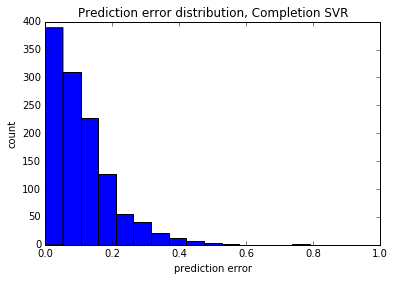

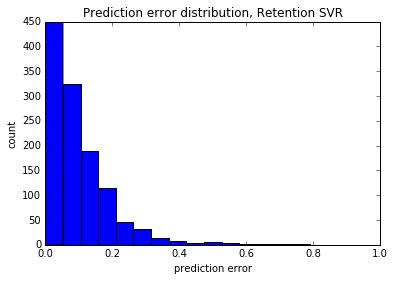

In [96]:
hist_plot_delta(SVR_model, X_test, y_test, model_name='SVR')

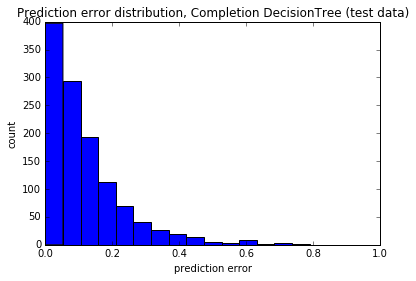

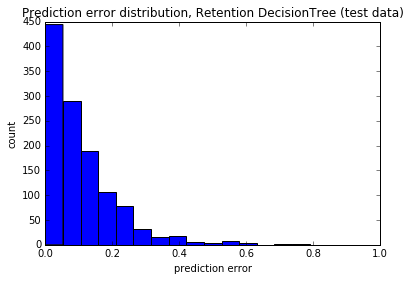

In [97]:
hist_plot_delta(DT_model, X_test, y_test, model_name='DecisionTree (test data)')
# hist_plot_delta(DT_model, X_train, y_train, model_name='DecisionTree (train data)')

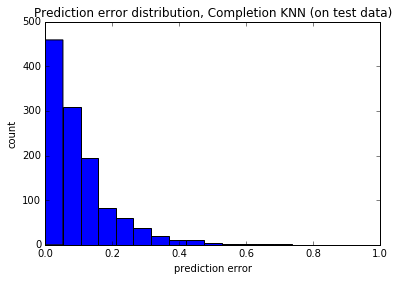

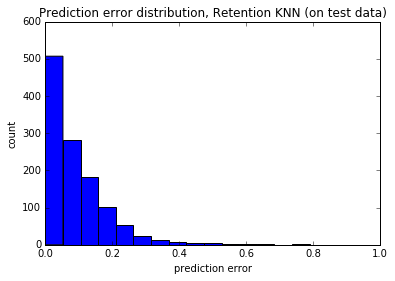

In [98]:
hist_plot_delta(KNN_model, X_test, y_test, model_name='KNN (on test data)')
# hist_plot_delta(KNN_model, X_train, y_train, model_name='KNN (on train data)')

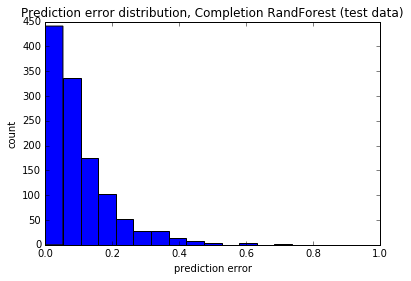

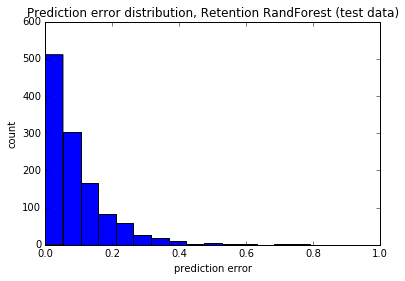

In [99]:
hist_plot_delta(RF_model, X_test, y_test, model_name='RandForest (test data)')
# hist_plot_delta(RF_model, X_train, y_train, model_name='RandForest (train data)')

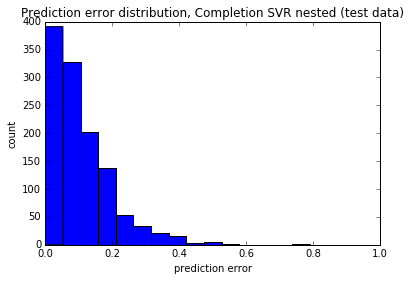

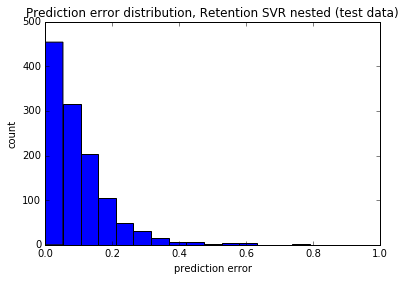

In [100]:
hist_plot_delta(SVR_nested, X_test[:,:23], y_test[:,:23], model_name='SVR nested (test data)', nested=True)
# hist_plot_delta(SVR_nested, X_train, y_train, model_name='SVR nested (train data)')

### Error distribution comparison between models

The following histogram plots show how different models perform. Even though some models have similar R2 and MAE, they don't always make the same prediction. This comparison shows how the models trade off error distribution.

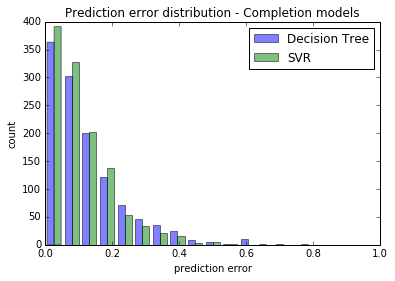

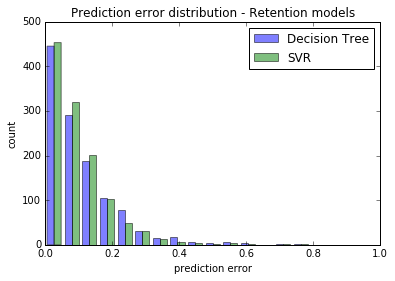

In [101]:
compare_hist_plot_delta(DT23_model, SVR23_model, X_test[:,:23], y_test[:,:23], ['Decision Tree', 'SVR'])

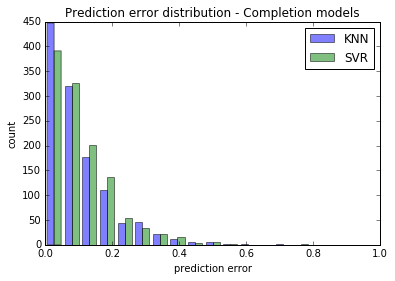

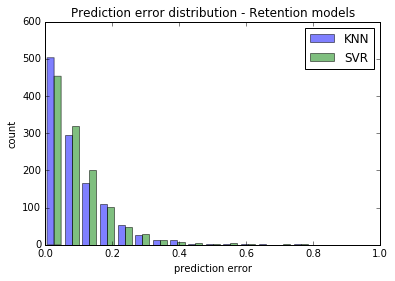

In [102]:
compare_hist_plot_delta(KNN23_model, SVR23_model, X_test[:,:23], y_test[:,:23], ['KNN', 'SVR'])

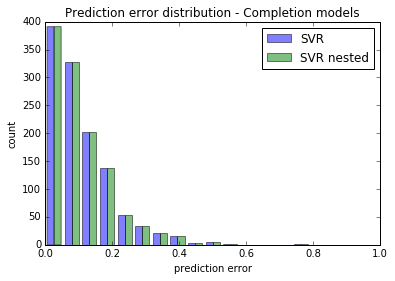

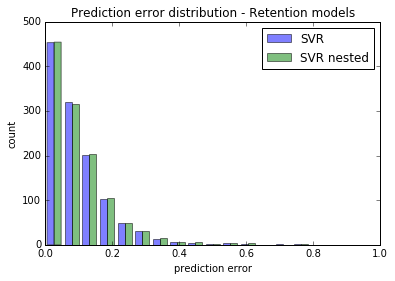

In [103]:
compare_hist_plot_delta(SVR23_model, SVR_nested, X_test[:,:23], y_test[:,:23], ['SVR', 'SVR nested'], nested=[False, True])